In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from urllib.request import urlopen
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from bs4 import BeautifulSoup as bs

In [288]:
def scrape_wikipedia(county, state):
    """
    Determines the population size of a county from its Wikipedia entry.
    Only works for counties in California.
    
    This is currently a bit hacky.
    
    Inputs:
        county: string. case-sensitive.
        state: string. state in which county is. case-sensitive.
        
    Outputs:
        pop: int.
    """
    
    form_county = county.replace(" ", "_")
    query = f'''https://en.wikipedia.org/wiki/{form_county}''' + f'_County,_{state}'
    urlpath = urlopen(query)
    soup = BeautifulSoup(urlpath, "lxml")

    right_table=soup.find('table', class_='infobox geography vcard')
    right_table.find_all('td')
    pop = eval([t.text.replace(',','').split("[", 1)[0] \
                for t in right_table.find_all('td') \
                if t.text.replace(',','').split("[", 1)[0] \
                .isnumeric()][0])
    return pop

In [311]:
def plot_county_new_cases(county, state='California', fractional=False):
    '''
    Plots the new cases indicator for new COVID-19 cases.
    Only works for counties in California.
    
    Inputs:
        county: string. case-sensitive.
        state: string. state in which county is. defaults to California.
        fractional: bool. Determines whether y-axis is in fraction of population or true case numbers.
    
    '''
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
    response = urlopen(url)
    cr = pd.read_csv(response)
    date_cols = [c for c in cr.columns if '/' in c]
    dates = cr[date_cols]
    new_cases = dates.diff(axis=1)
    new_cases['County'] = cr['Admin2']
    new_cases['State'] = cr['Province_State']
    corr_county = new_cases['County']==county
    corr_state = new_cases['State']==state
    county_new = new_cases[corr_county & corr_state].values[0][1:-3]
    last_14 = [np.sum(county_new[i-14:i]) for i in range(14, len(county_new))]
    
    tick_spacing=15

    pop_size = scrape_wikipedia(county, state)
    thresh=1/10000

    fig, ax = plt.subplots(1,1, figsize=(11,11))
    ax.set_title(f'New confirmed COVID-19 cases in {county} County', fontsize=20)
    
    if fractional:
        ax.plot(date_cols[15:-1], last_14/pop_size, color='gray')
        rect = patches.Rectangle((-10,thresh),180,3000, linewidth=1,edgecolor='r',
                             facecolor='lightcoral', alpha=.5,
                            label='State-wide indicator')
        ax.set_ylabel('New cases (fraction of county population)', fontsize=20);
        ax.set_ylim(0, 1.2*max(thresh, max(last_14/pop_size)))


    else:
        ax.plot(date_cols[15:-1], last_14, color='gray')
        rect = patches.Rectangle((-10,thresh * pop_size),180,3000, linewidth=1,edgecolor='r',
                             facecolor='lightcoral', alpha=.5,
                            label='CA new-case indicator')
        ax.set_ylabel('New cases within 14-day period', fontsize=20);
        ax.set_ylim(0, 1.2*max(thresh*pop_size, max(last_14)))


    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xlabel('Date', fontsize=20)
    ax.axvline(x='3/19/20', color='blue', 
               label="""'Strict' CA stay-at-home order goes into effect""",
              linestyle='--')
    ax.add_patch(rect)

    plt.legend(fontsize=20,)
    print(pop_size)

1781642


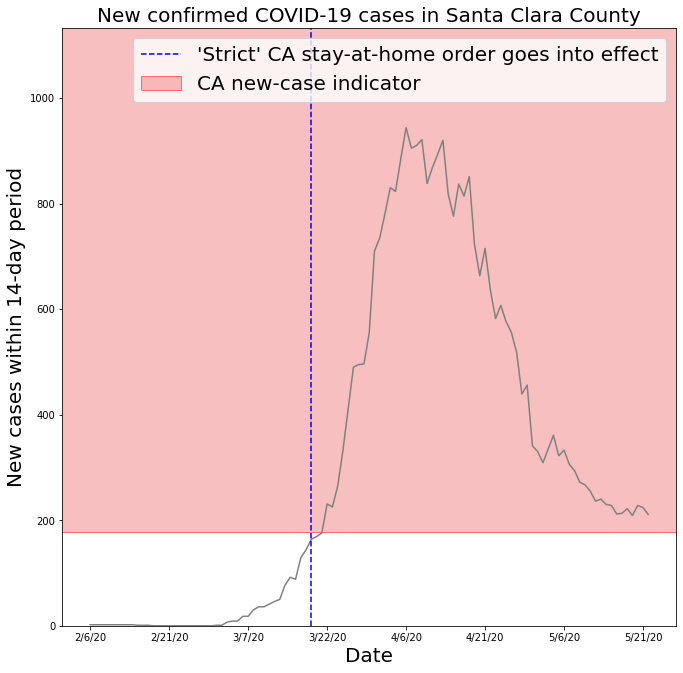

In [315]:
plot_county_new_cases('Santa Clara')